# WB PD3 - analiza epsilon w algorytmie On-policy first-visit MC control
## Zadanie
Dla wybranej przez siebie gry na siatce (np. jednej z możliwych do wyboru z PD2) zanalizuj wpływ parametru epsilon na prędkość zbieżności algorytmu On-policy first-visit MC control.

Narysuj wykres, gdzie na osi OX jest wartość parametru epsilon, a na osi OY liczba epizodów, która była potrzebna do zbieżności algorytmu.

Jako kryterium zbieżności wybierz, że polityka nie zmieniła się od 100 epizodów.
## Wybrana gra
Modyfikacja przykładu 4.1 z książki ze strony 76. Plansza jest 7x7. Gracz może się po niej poruszać w 4 kierunkach. Gdy będzie próbował wejść w ścianę, to jego pozycja się nie zmienia. Za każdym ruchem dostaje "nagrodę" -1. Koniec gry następuje, gdy wejdzie do prawego dolnego albo lewego górnego rogu. Idąc w prawo, gracz przechodzi dwa pola zamiast jednego (jeżeli jest o jedno pole od ściany, to jedynie idzie o jedno pole).

In [1]:
import numpy as np
import pandas as pd

In [2]:
#gra
#niech zaczyna w dolnym lewnym rogu
start = (6,0)
end = [(6, 6), (0, 0)]
acts = ['UP', 'DOWN', 'LEFT', 'RIGHT']

#ruchy
def take_action(state, action):
    r,c = state

    if action == 'UP':
        next_state = (max(r - 1, 0), c)
    elif action == 'DOWN':
        next_state = (min(r + 1, 6), c)
    elif action == 'LEFT':
        next_state = (r, max(c - 1, 0))
    elif action == 'RIGHT':
        if c == 5:
            next_state = (r, 6)
        else:
            next_state = (r, min(c + 2, 6))
    reward = -1

    return next_state, reward

# update polityki
def update_policy(state, policy, epsilon, Q, A=acts):
    best_actions = [a for a in A if Q[state][a] == max(Q[state].values())]
    policy[state] = {a: 0 for a in A}
    for a in A:
        if (len(A)-len(best_actions))==0:
            policy[state][a]=1/len(A)
        elif a in best_actions:
            policy[state][a] = (1 - epsilon)/len(best_actions)
        else:
            policy[state][a] = epsilon/(len(A)-len(best_actions))
    return policy
        
            
#stosowanie polityki
def choose_action(state, policy):
    acts = list(policy[state].keys())
    probabilities = list(policy[state].values())
    return np.random.choice(acts, p=probabilities)

# Algorytm 
def first_visit_mc_control(epsilon, episodes=5000, A=acts):
    policy = {}
    Q = {}
    returns = {}
    count= 0 #do zliczania epizodów bez zmiany polityki

    #nie mamy informacji zadnych jeszcze, wiec random
    for i in range(7):
        for j in range(7):
            state = (i, j)
            policy[state] = {a: 0.25 for a in A}
            Q[state] = {a: 0 for a in A}
            returns[state] = {a: [] for a in A}

    for ep in range(episodes):
        state = start
        states = [state]
        rewards = [0]
        G=0
        actions=[]

        while state not in end:
            action = choose_action(state,policy)
            next_state, reward = take_action(state, action)
            states.append(next_state)
            actions.append(action)
            rewards.append(reward)
            state = next_state

        for t in reversed(range(len(states) - 1)):
            state = states[t]
            action = actions[t]
            reward = rewards[t + 1]
            G = reward + G
            if (state, action) not in zip(states[:t], actions[:t]):
                old_policy=policy.copy()
                returns[state][action].append(G)
                Q[state][action] = np.mean(returns[state][action])
                new_policy=update_policy(state, policy, epsilon, Q)
                if new_policy!=old_policy:
                    count=0
                policy=new_policy
        count+=1
        if count==100:
            break
    return ep

In [7]:
# badanie zbieznosci 
epsilons = np.linspace(0.005, 0.4, 12)
nr_of_episodes = {eps: 0 for eps in epsilons}

for epsilon in epsilons:
    avg_nr=0
    for i in range(10):
        avg_nr+=first_visit_mc_control(epsilon)
    nr_of_episodes[epsilon] = avg_nr/10


In [11]:
df = pd.DataFrame(list(nr_of_episodes.items()), columns=['epsilon', 'nr_of_episodes'])
nr_of_episodes

{0.005: 129.4,
 0.04090909090909091: 225.8,
 0.07681818181818183: 182.3,
 0.11272727272727273: 181.6,
 0.14863636363636365: 237.1,
 0.18454545454545457: 251.0,
 0.22045454545454546: 314.2,
 0.2563636363636364: 295.7,
 0.2922727272727273: 307.6,
 0.3281818181818182: 456.1,
 0.36409090909090913: 401.7,
 0.4: 429.0}

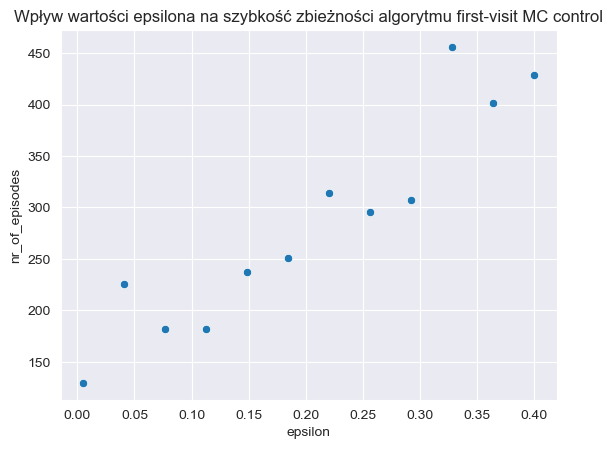

In [9]:
# Wykres
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="epsilon", y="nr_of_episodes")
plt.title('Wpływ wartości epsilona na szybkość zbieżności algorytmu first-visit MC control')
plt.show()